week 4

In [2]:
# imports
!pip install statsmodels
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 31.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] [statsmodels]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
hw4_df = pd.read_csv('homework_4.1.csv')
hw4_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5000 non-null   int64  
 1   Z           5000 non-null   int64  
 2   W           5000 non-null   float64
 3   X           5000 non-null   float64
 4   Y           5000 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 195.4 KB


In [4]:
hw4_df.head()

,Unnamed: 0,Z,W,X,Y
0,0,0,-0.155644,-0.496971,0.282484
1,1,1,0.529539,2.284240,4.740596
2,2,1,0.910514,0.872232,3.449569
3,3,1,-0.705476,2.157260,3.002531
4,4,0,-0.590874,-0.386730,-1.848796


In [5]:
# question 2

# --- Subtract the average Y value for Z=1 and Z=0.
    # Subtract the average X value for Z=1 and Z=0. Divide the two. ---
mean_Y_Z1 = hw4_df.loc[hw4_df["Z"] == 1, "Y"].mean()
mean_Y_Z0 = hw4_df.loc[hw4_df["Z"] == 0, "Y"].mean()
mean_X_Z1 = hw4_df.loc[hw4_df["Z"] == 1, "X"].mean()
mean_X_Z0 = hw4_df.loc[hw4_df["Z"] == 0, "X"].mean()

wald_unconditional = (mean_Y_Z1 - mean_Y_Z0) / (mean_X_Z1 - mean_X_Z0)

print("Unconditional Wald estimator:", wald_unconditional)

# --- Find the average Y value for Z=1 and Z=0 for a narrow range of W.
    # Find the average X value for Z=1 and Z=0 for the same narrow range of W. 
    # Take the ratio to find the effect. Then average this over all the ranges of W. ---

# bin W into quantile ranges (e.g., deciles)
hw4_df["W_bin"] = pd.qcut(hw4_df["W"], q=10, duplicates="drop")

wald_by_bin = []
for b, group in hw4_df.groupby("W_bin"):
    if group["Z"].nunique() < 2:  # need both Z=0 and Z=1 in the bin
        continue
    dY = group.loc[group["Z"] == 1, "Y"].mean() - group.loc[group["Z"] == 0, "Y"].mean()
    dX = group.loc[group["Z"] == 1, "X"].mean() - group.loc[group["Z"] == 0, "X"].mean()
    if dX != 0:
        wald_by_bin.append(dY / dX)

wald_conditional = np.mean(wald_by_bin)

print("Conditional Wald estimator (averaged over W bins):", wald_conditional)

Unconditional Wald estimator: 1.5618587073955674
Conditional Wald estimator (averaged over W bins): 1.5088963715407195


/tmp/ipykernel_7168/100882209.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for b, group in hw4_df.groupby("W_bin"):


In [9]:
hw4a_df = pd.read_csv('homework_4.2.a.csv')
hw4b_df = pd.read_csv('homework_4.2.b.csv')


=== Dataset A ===
Cutoff: 50
Mean outcome above: 0.2793791574279379
Mean outcome below: 0.29411764705882354
Difference in means: -0.014738489630885643
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.2384      0.675     -0.353      0.724      -1.564       1.087
above_cutoff    -0.0707      0.085     -0.835      0.404      -0.237       0.096
X                0.0111      0.014      0.791      0.429      -0.016       0.039


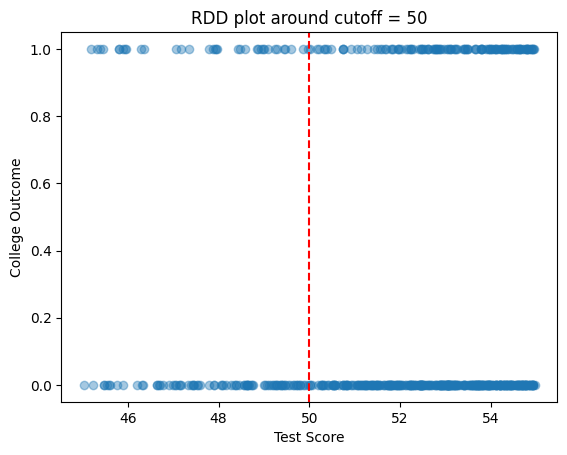


=== Dataset B ===
Cutoff: 50
Mean outcome above: 0.41226215644820297
Mean outcome below: 0.37719298245614036
Difference in means: 0.03506917399206261
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.4536      0.688     -0.659      0.510      -1.805       0.898
above_cutoff    -0.0496      0.087     -0.572      0.568      -0.220       0.121
X2               0.0173      0.014      1.210      0.227      -0.011       0.045


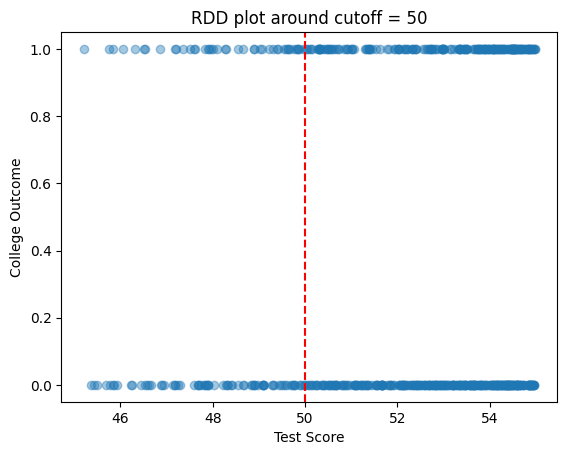

In [13]:
# Q3

import matplotlib.pyplot as plt

def run_rdd(df, cutoff, score_col, outcome_col, window=5):
    # restrict to a window around cutoff (local comparison)
    local = df[(df[score_col] >= cutoff - window) & (df[score_col] <= cutoff + window)].copy()
    local["above_cutoff"] = (local[score_col] >= cutoff).astype(int)
    
    # 1. simple difference in means
    mean_Y_above = local.loc[local["above_cutoff"] == 1, outcome_col].mean()
    mean_Y_below = local.loc[local["above_cutoff"] == 0, outcome_col].mean()
    diff_means = mean_Y_above - mean_Y_below
    
    # 2. local linear regression
    X_design = sm.add_constant(local[["above_cutoff", score_col]])
    model = sm.OLS(local[outcome_col], X_design).fit()
    
    print("Cutoff:", cutoff)
    print("Mean outcome above:", mean_Y_above)
    print("Mean outcome below:", mean_Y_below)
    print("Difference in means:", diff_means)
    print(model.summary().tables[1])
    
    # visualization
    plt.scatter(local[score_col], local[outcome_col], alpha=0.4)
    plt.axvline(cutoff, color="red", linestyle="--")
    plt.title(f"RDD plot around cutoff = {cutoff}")
    plt.xlabel("Test Score")
    plt.ylabel("College Outcome")
    plt.show()

# run on both datasets:
print("=== Dataset A ===")
run_rdd(hw4a_df, cutoff=50, score_col="X", outcome_col="Y")

print("\n=== Dataset B ===")
run_rdd(hw4b_df, cutoff=50, score_col="X2", outcome_col="Y2")


In [11]:
print(hw4b_df.columns)
hw4b_df.head()

Index(['Unnamed: 0', 'X2', 'Y2'], dtype='object')


,Unnamed: 0,X2,Y2
0,0,76.643034,1
1,1,87.743397,1
2,2,81.639469,1
3,3,73.740485,0
4,4,90.480268,1


In [16]:
def run_rdd_with_slope(df, cutoff, score_col, outcome_col, window=5):
    # restrict to a window around cutoff
    local = df[(df[score_col] >= cutoff - window) & (df[score_col] <= cutoff + window)].copy()
    local["above_cutoff"] = (local[score_col] >= cutoff).astype(int)
    local["interaction"] = local["above_cutoff"] * local[score_col]
    
    # 1. Simple difference in means
    mean_Y_above = local.loc[local["above_cutoff"] == 1, outcome_col].mean()
    mean_Y_below = local.loc[local["above_cutoff"] == 0, outcome_col].mean()
    diff_means = mean_Y_above - mean_Y_below
    
    # 2. Local linear regression with interaction
    X_design = sm.add_constant(local[["above_cutoff", score_col, "interaction"]])
    model = sm.OLS(local[outcome_col], X_design).fit()
    
    print("Cutoff:", cutoff)
    print("Mean outcome above:", mean_Y_above)
    print("Mean outcome below:", mean_Y_below)
    print("Difference in means:", diff_means)
    print(model.summary().tables[1])
    
    # Compute slope before and after cutoff
    slope_before = model.params[score_col]
    slope_after = slope_before + model.params["interaction"]
    print(f"Slope before cutoff: {slope_before:.4f}")
    print(f"Slope after cutoff: {slope_after:.4f}")
    
    # Visualization
    plt.scatter(local[score_col], local[outcome_col], alpha=0.4)
    plt.axvline(cutoff, color="red", linestyle="--")
    plt.title(f"RDD plot around cutoff = {cutoff}")
    plt.xlabel("Test Score")
    plt.ylabel("College Outcome")
    plt.show()



/tmp/ipykernel_7168/3092522090.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = subset.groupby("X_bin")["Y"].mean().reset_index()


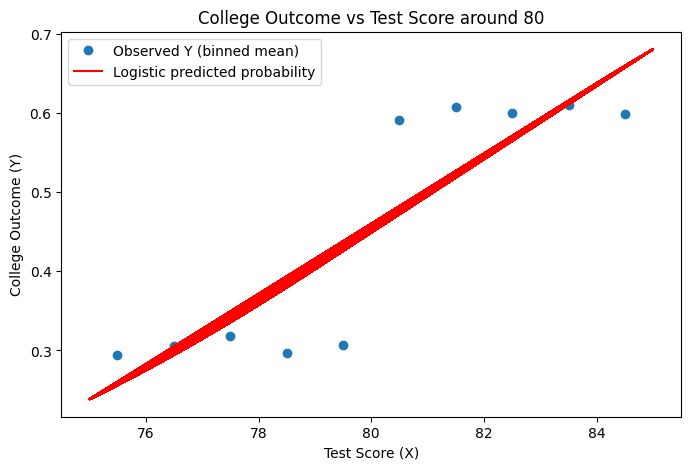

In [25]:
# Choose a narrow window around X = 80
window = 5
subset = hw4a_df[(hw4a_df["X"] >= 80 - window) & (hw4a_df["X"] <= 80 + window)].copy()

# Logistic regression
X_design = sm.add_constant(subset["X"])
logit_model = sm.Logit(subset["Y"], X_design).fit(disp=0)
subset["Y_pred"] = logit_model.predict(X_design)
subset["X_bin"] = pd.cut(subset["X"], bins=10)
binned = subset.groupby("X_bin")["Y"].mean().reset_index()
binned_mid = [interval.mid for interval in binned["X_bin"]]

# Jitter for readability
np.random.seed(0)
subset["Y_jitter"] = subset["Y"] + np.random.uniform(-0.03, 0.03, size=len(subset))

# Plot
plt.figure(figsize=(8,5))
plt.plot(binned_mid, binned["Y"], "o", label="Observed Y (binned mean)")
plt.plot(subset["X"], subset["Y_pred"], color="red", label="Logistic predicted probability")
plt.xlabel("Test Score (X)")
plt.ylabel("College Outcome (Y)")
plt.title("College Outcome vs Test Score around 80")
plt.legend()
plt.show()
